In [1]:
# Mount GDRIVE
from google.colab import drive
drive.mount('/content/drive')

PATH = '/content/drive/MyDrive/'

Mounted at /content/drive


In [2]:
# Install some packages
!pip install rasterio
!pip install earthpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.9 MB/s eta 0:00:00


In [3]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
import earthpy.plot as ep
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import Model
from matplotlib.colors import from_levels_and_colors
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
np.random.seed(123)
tf.random.set_seed(123)
tf.keras.utils.set_random_seed(123)

In [26]:
# Parameter
CLASSES     = ['Air', 'Lahan Terbangun', 'Vegetasi']
N_CLASSES   = len(CLASSES)
PALETTE     = ['#F08080', '#D2B48C', '#87CEFA']
IMAGE_PATH  = PATH + 'Sentinel2_Export/Sentinel2_with_NDVI_2021.tif'

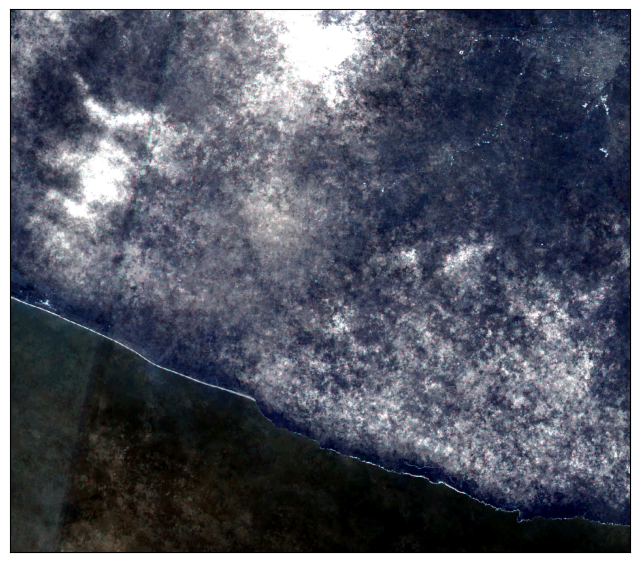

<Axes: >

In [27]:
# Load image
image = rasterio.open(IMAGE_PATH)
# bandNum = image.count
height = image.height
width = image.width
# crs = image.crs
# transform = image.transform
shape = (height, width)

image_vis = []
for x in range(1, len(CLASSES)+1):
    image_vis.append(image.read(x))
image_vis = np.stack(image_vis)


plot_size = (8, 8)
ep.plot_rgb(
  image_vis,
  figsize=plot_size,
  stretch=True,
)

In [28]:
# Function to reshape array input
def reshape_input(array):
  shape = array.shape
  return array.reshape(shape[0], shape[1], 1)

# Fungsi untuk mengklasifikasikan nilai NDVI
def classify_ndvi(ndvi_values):
    classified_ndvi = np.empty_like(ndvi_values, dtype='object')
    classified_ndvi[(ndvi_values <= 0)] = "Air"
    classified_ndvi[((ndvi_values > 0) & (ndvi_values <= 0.2))] = "Lahan Bangunan"
    classified_ndvi[(ndvi_values > 0.2)] = "Vegetasi"
    return classified_ndvi

In [29]:
# Buka file GeoTIFF
with rasterio.open(IMAGE_PATH) as src:
    # Baca data piksel untuk band B4 dan B8
    nir_band = src.read(1)  # Band 1 corresponds to B4
    red_band = src.read(4)  # Band 4 corresponds to B8

    # Hitung nilai piksel maksimum untuk normalisasi
    max_pixel_value = max(nir_band.max(), red_band.max())

    # Normalisasi nilai piksel B4 dan B8 ke rentang [0, 1]
    nir_band_normalized = nir_band.astype(float) / max_pixel_value
    red_band_normalized = red_band.astype(float) / max_pixel_value

    # Hitung NDVI
    ndvi = (nir_band_normalized - red_band_normalized) / (nir_band_normalized + red_band_normalized)

    # Membatasi hasil NDVI ke rentang -1 hingga 1
    ndvi = ndvi.clip(-1, 1)

    # Klasifikasi NDVI
    classified_ndvi = classify_ndvi(ndvi)

image_input = np.stack((nir_band_normalized.flatten(), red_band_normalized.flatten()), axis=1)  # Stack bands B4 and B8 to create image array
image_reshape = reshape_input(image_input.reshape(len(CLASSES)-1, -1).T)
image_reshape

array([[[0.31758775],
        [0.22806199]],

       [[0.23170276],
        [0.36634149]],

       [[0.33121733],
        [0.25093353]],

       ...,

       [[0.37070575],
        [0.12770724]],

       [[0.24337192],
        [0.30293129]],

       [[0.36613144],
        [0.12752054]]])

In [30]:
df = pd.DataFrame(image_input)
df.columns = ['B4', 'B8']
df['label'] = classified_ndvi.flatten()
df

,B4,B8,label
0,0.317588,0.231703,Lahan Bangunan
1,0.331217,0.236557,Lahan Bangunan
2,0.378547,0.215646,Vegetasi
3,0.342420,0.203603,Vegetasi
4,0.341440,0.223799,Vegetasi
...,...,...,...
788614,0.294287,0.128018,Vegetasi
788615,0.293017,0.126867,Vegetasi
788616,0.301811,0.127259,Vegetasi
788617,0.302511,0.127707,Vegetasi


In [31]:
# Split data
X = df[['B4', 'B8']] # menggunakan B4 dan B8
y = df['label']

In [32]:
# Label encoder
le = LabelEncoder()
le.fit(y)

y = le.fit_transform(y)

In [33]:
# Convert samples dataframe (pandas) to numpy array
test_input = reshape_input(np.array(X))

# Also make label data to categorical
test_output = to_categorical(y, N_CLASSES)

In [34]:
model_path = PATH + 'cnn_model.h5'
n_model = load_model(model_path)

# Predict test data
prediction = np.argmax(n_model.predict(test_input), 1).flatten()
label      = np.argmax(test_output, 1).flatten()

24645/24645 [==============================] - 120s 5ms/step


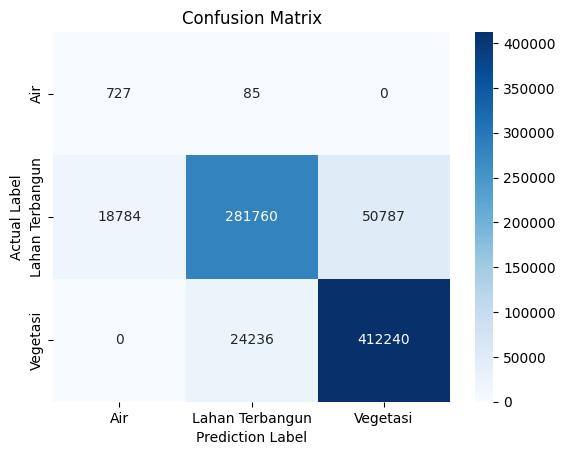

In [35]:
cm           = confusion_matrix(label, prediction)
df_confusion = pd.DataFrame(cm, index = CLASSES, columns = CLASSES)

sns.heatmap(df_confusion, annot=True, fmt = "d", cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Prediction Label')
plt.ylabel('Actual Label')
plt.show()

In [36]:
accuracy_  = round(accuracy_score(label, prediction)*100, 2)
precision_ = round(precision_score(label, prediction, average='weighted')*100, 2)
recall_    = round(recall_score(label, prediction, average='weighted')*100, 2)
f1_score_  = round(f1_score(label, prediction, average='weighted')*100, 2)

print('Accuracy  : ', accuracy_)
print('Precision : ', precision_)
print('Recall    : ', recall_)
print('F1-score  : ', f1_score_)

Accuracy  :  88.09
Precision :  90.29
Recall    :  88.09
F1-score  :  88.93
